In [53]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer

In [55]:
# CSV 읽기
df = pd.read_csv('/content/drive/MyDrive/asos_Seoul_2012-2021.csv')

print("📌 데이터프레임 크기:", df.shape)
print(df.head())
print("\n📌 컬럼명:")
print(df.columns.tolist())


📌 데이터프레임 크기: (87672, 38)
              Date  Site_No   Site  Tair_C  Tair_flag  Rain_mm  Rain_flag  \
0  2012-01-01 0:00      108  Seoul     0.4        0.0      NaN        NaN   
1  2012-01-01 1:00      108  Seoul     0.3        0.0      NaN        NaN   
2  2012-01-01 2:00      108  Seoul    -0.1        0.0      NaN        NaN   
3  2012-01-01 3:00      108  Seoul    -0.5        0.0      NaN        NaN   
4  2012-01-01 4:00      108  Seoul    -1.2        0.0      NaN        NaN   

   WS_m_s  WS_flag  WD_16deg  WD_flag  RH_pct  RH_flag  Pv_hPa  Td_C  Pa_hPa  \
0     1.5      0.0     250.0      0.0    69.0      0.0     4.3  -4.6  1014.2   
1     2.3      0.0     270.0      0.0    72.0      0.0     4.5  -4.1  1013.9   
2     1.3      0.0     290.0      0.0    73.0      0.0     4.4  -4.3  1013.7   
3     0.8      0.0     270.0      0.0    74.0      0.0     4.4  -4.5  1013.6   
4     1.5      0.0     290.0      0.0    77.0      0.0     4.3  -4.7  1013.5   

   Pa_flag  Psfc_hPa  Psfc_flag

In [56]:
df['Datetime'] = pd.to_datetime(df['Date'], errors='coerce')

print("📌 Datetime 파싱 확인:")
print(df['Datetime'].head())


📌 Datetime 파싱 확인:
0   2012-01-01 00:00:00
1   2012-01-01 01:00:00
2   2012-01-01 02:00:00
3   2012-01-01 03:00:00
4   2012-01-01 04:00:00
Name: Datetime, dtype: datetime64[ns]


In [57]:
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek

df[['year', 'month', 'day', 'hour', 'dayofweek']].head()


,year,month,day,hour,dayofweek
0,2012,1,1,0,6
1,2012,1,1,1,6
2,2012,1,1,2,6
3,2012,1,1,3,6
4,2012,1,1,4,6


In [58]:
def split_phen(x):
    if pd.isna(x):
        return []
    x = str(int(x))  # 소수점 제거
    if len(x) % 2 != 0:
        # 홀수면 앞에 0을 붙여서 맞춤
        x = '0' + x
    return [x[i:i+2] for i in range(0, len(x), 2)]

# 테스트
print("📌 Phen 10개 샘플 분해:")
print(df['Phen'].head(10).apply(split_phen))


📌 Phen 10개 샘플 분해:
0    [40]
1    [40]
2    [40]
3    [40]
4    [40]
5    [40]
6    [40]
7    [40]
8    [40]
9    [40]
Name: Phen, dtype: object


In [59]:
df['Phen_labels'] = df['Phen'].apply(split_phen)

print("📌 Phen_labels 예시:")
print(df[['Phen', 'Phen_labels']].head(15))


📌 Phen_labels 예시:
      Phen Phen_labels
0     40.0        [40]
1     40.0        [40]
2     40.0        [40]
3     40.0        [40]
4     40.0        [40]
5     40.0        [40]
6     40.0        [40]
7     40.0        [40]
8     40.0        [40]
9     40.0        [40]
10  4005.0    [40, 05]
11  4005.0    [40, 05]
12    40.0        [40]
13    40.0        [40]
14  4005.0    [40, 05]


In [60]:
feature_cols = [
    'Tair_C', 'RH_pct', 'WS_m_s', 'Rain_mm',
    'Tsfc_C', 'T5cm_C', 'T10cm_C', 'T20cm_C', 'T30cm_C',
    'Cloud_cover_total', 'Cloud_cover_mid_low', 'Vis_10m',
    'Sunrad_MJ_m2', 'Suntime_hr', 'Snow_cm', 'Snow_3hr_cm',
    'WD_16deg', 'Pv_hPa', 'Td_C', 'Pa_hPa', 'Psfc_hPa',
    'hour', 'month', 'dayofweek'
]

X = df[feature_cols]
Y = df['Phen_labels']


In [61]:
print("📌 입력 피처 결측 개수:")
print(X.isna().sum())


📌 입력 피처 결측 개수:
Tair_C                     8
RH_pct                    48
WS_m_s                    56
Rain_mm                79029
Tsfc_C                    75
T5cm_C                    72
T10cm_C                   73
T20cm_C                   87
T30cm_C                  177
Cloud_cover_total      13006
Cloud_cover_mid_low     9114
Vis_10m                 6275
Sunrad_MJ_m2           39960
Suntime_hr             40131
Snow_cm                83951
Snow_3hr_cm            87417
WD_16deg                 116
Pv_hPa                    15
Td_C                      38
Pa_hPa                    71
Psfc_hPa                  19
hour                       0
month                      0
dayofweek                  0
dtype: int64


In [62]:
df_clean = df.dropna(subset=feature_cols + ['Phen_labels']).copy()
X = df_clean[feature_cols]
Y = df_clean['Phen_labels']
print("📌 결측 제거 후:", df_clean.shape)


📌 결측 제거 후: (101, 45)


In [63]:
mlb = MultiLabelBinarizer()
Y_bin = mlb.fit_transform(Y)

print("📌 라벨 클래스 목록:", mlb.classes_)
print("📌 변환된 Y shape:", Y_bin.shape)


📌 라벨 클래스 목록: ['05' '06' '08' '10' '11' '16' '19' '40' '71']
📌 변환된 Y shape: (101, 9)


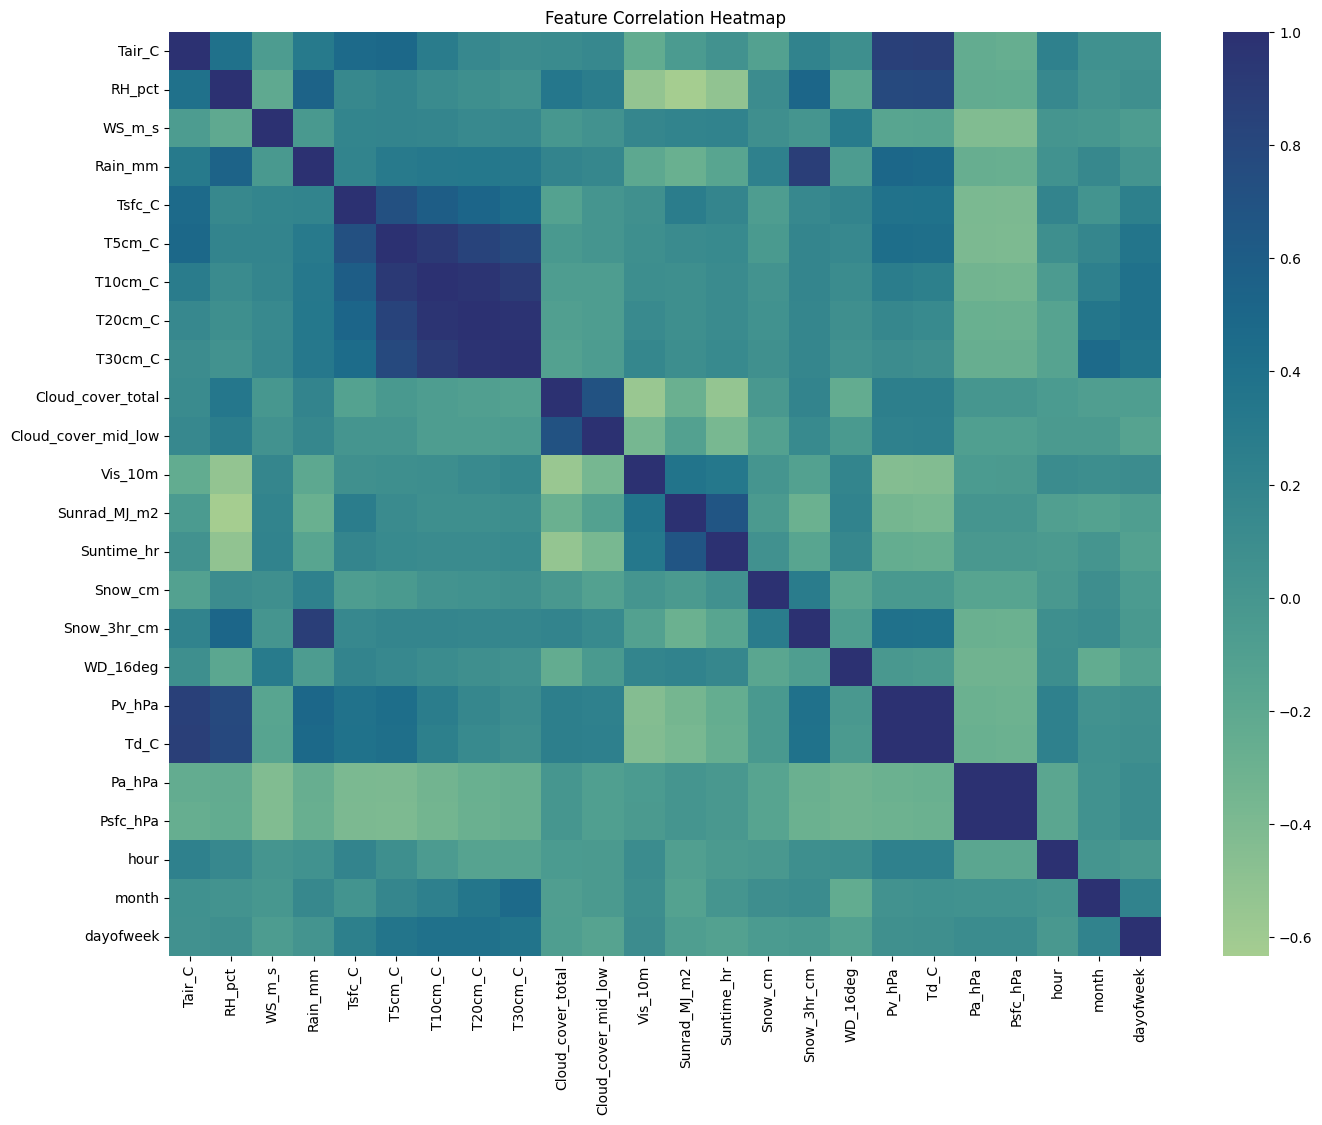

In [64]:
plt.figure(figsize=(16, 12))
sns.heatmap(X.corr(), annot=False, cmap='crest')
plt.title("Feature Correlation Heatmap")
plt.show()


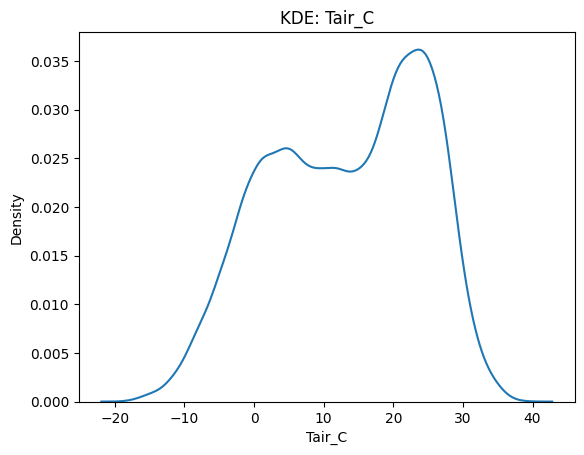

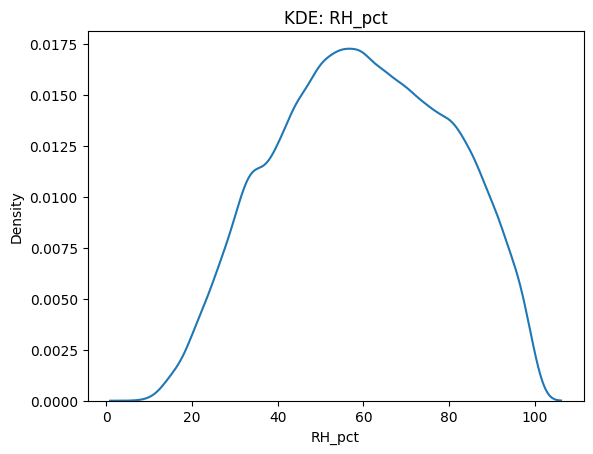

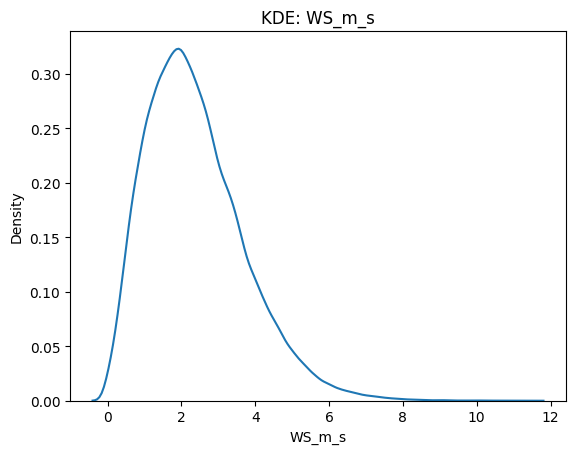

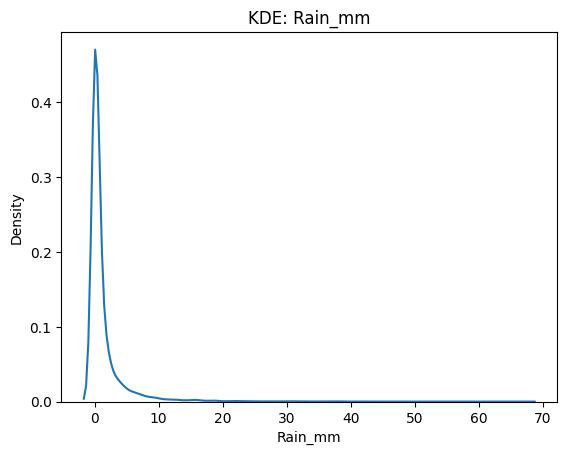

In [65]:
for col in ['Tair_C', 'RH_pct', 'WS_m_s', 'Rain_mm']:
    sns.kdeplot(df[col].dropna())
    plt.title(f"KDE: {col}")
    plt.show()


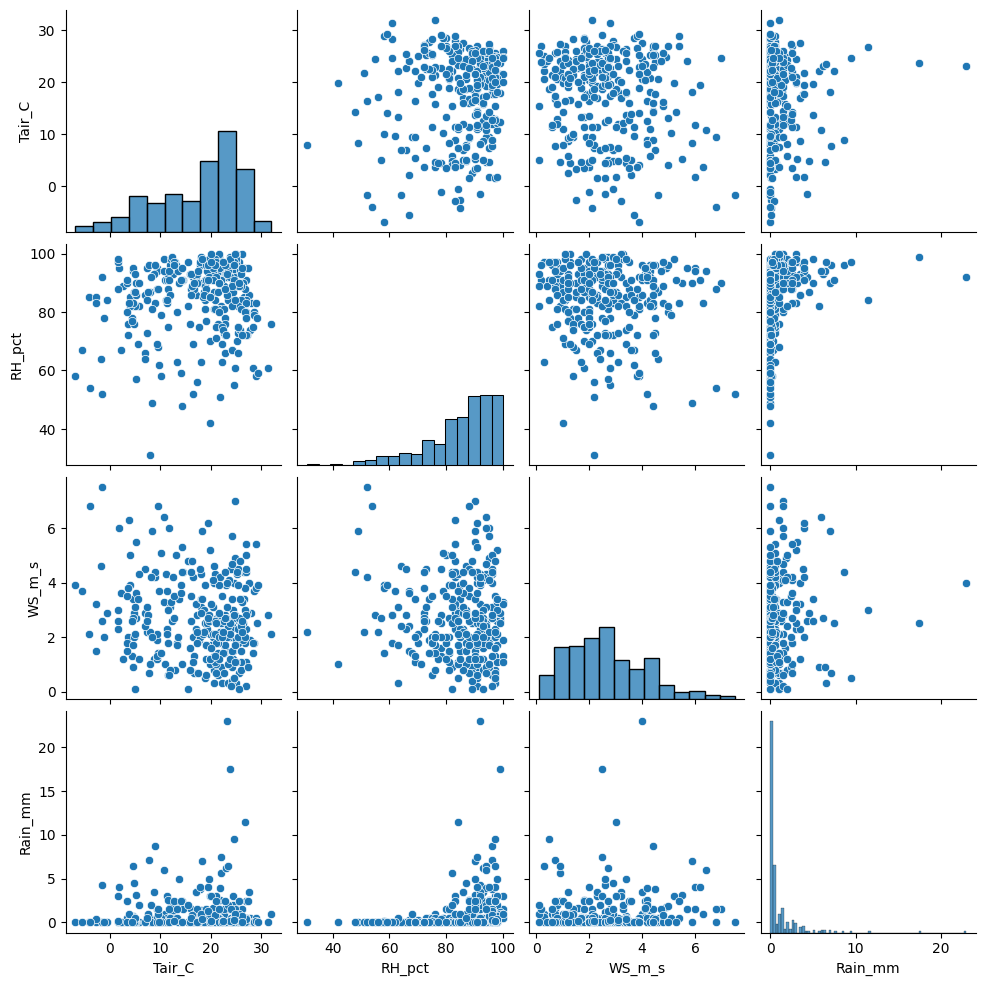

In [66]:
sns.pairplot(df[['Tair_C', 'RH_pct', 'WS_m_s', 'Rain_mm']].dropna().sample(300))
plt.show()


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_bin, test_size=0.2, random_state=42
)


In [68]:
model = OneVsRestClassifier(RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=12
))

model.fit(X_train, Y_train)


OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=12,
                                                     n_estimators=200,
                                                     random_state=42))

In [69]:
Y_pred = model.predict(X_test)

print("📌 Accuracy:", accuracy_score(Y_test, Y_pred))
print("\n📌 Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


📌 Accuracy: 0.2857142857142857

📌 Classification Report:
              precision    recall  f1-score   support

          05       0.62      1.00      0.76        13
          06       0.00      0.00      0.00         1
          08       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         5
          40       0.00      0.00      0.00         2
          71       0.00      0.00      0.00         0

   micro avg       0.57      0.52      0.54        25
   macro avg       0.07      0.11      0.08        25
weighted avg       0.32      0.52      0.40        25
 samples avg       0.57      0.50      0.51        25



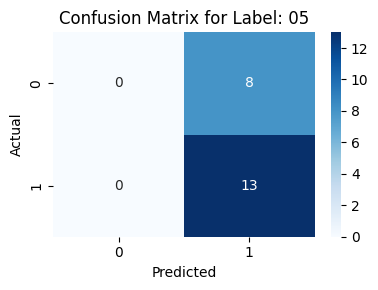

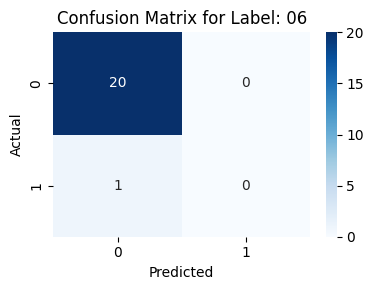

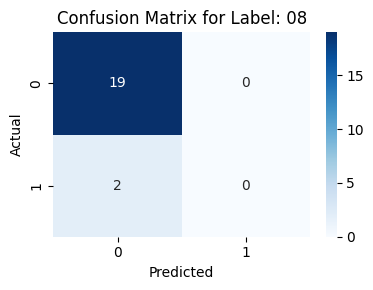

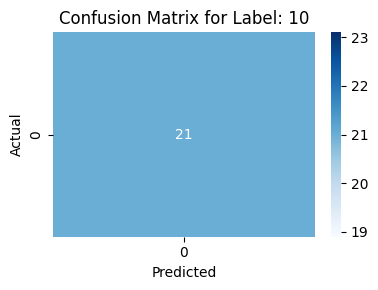

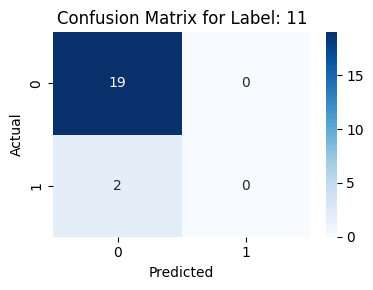

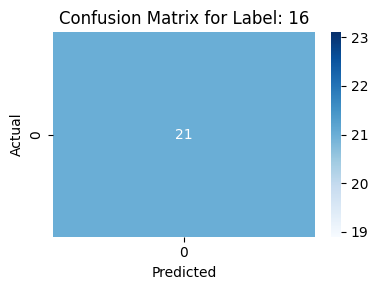

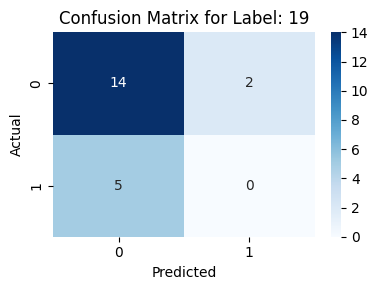

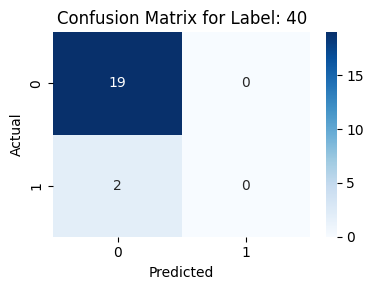

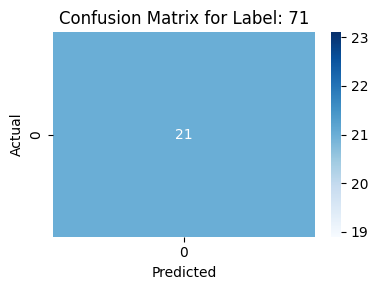

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측
Y_pred = model.predict(X_test)

# 라벨 이름 가져오기 (mlb는 MultiLabelBinarizer)
label_names = mlb.classes_

# 각 클래스별로 혼동행렬 출력
for i, label in enumerate(label_names):
    cm = confusion_matrix(Y_test[:, i], Y_pred[:, i])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for Label: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


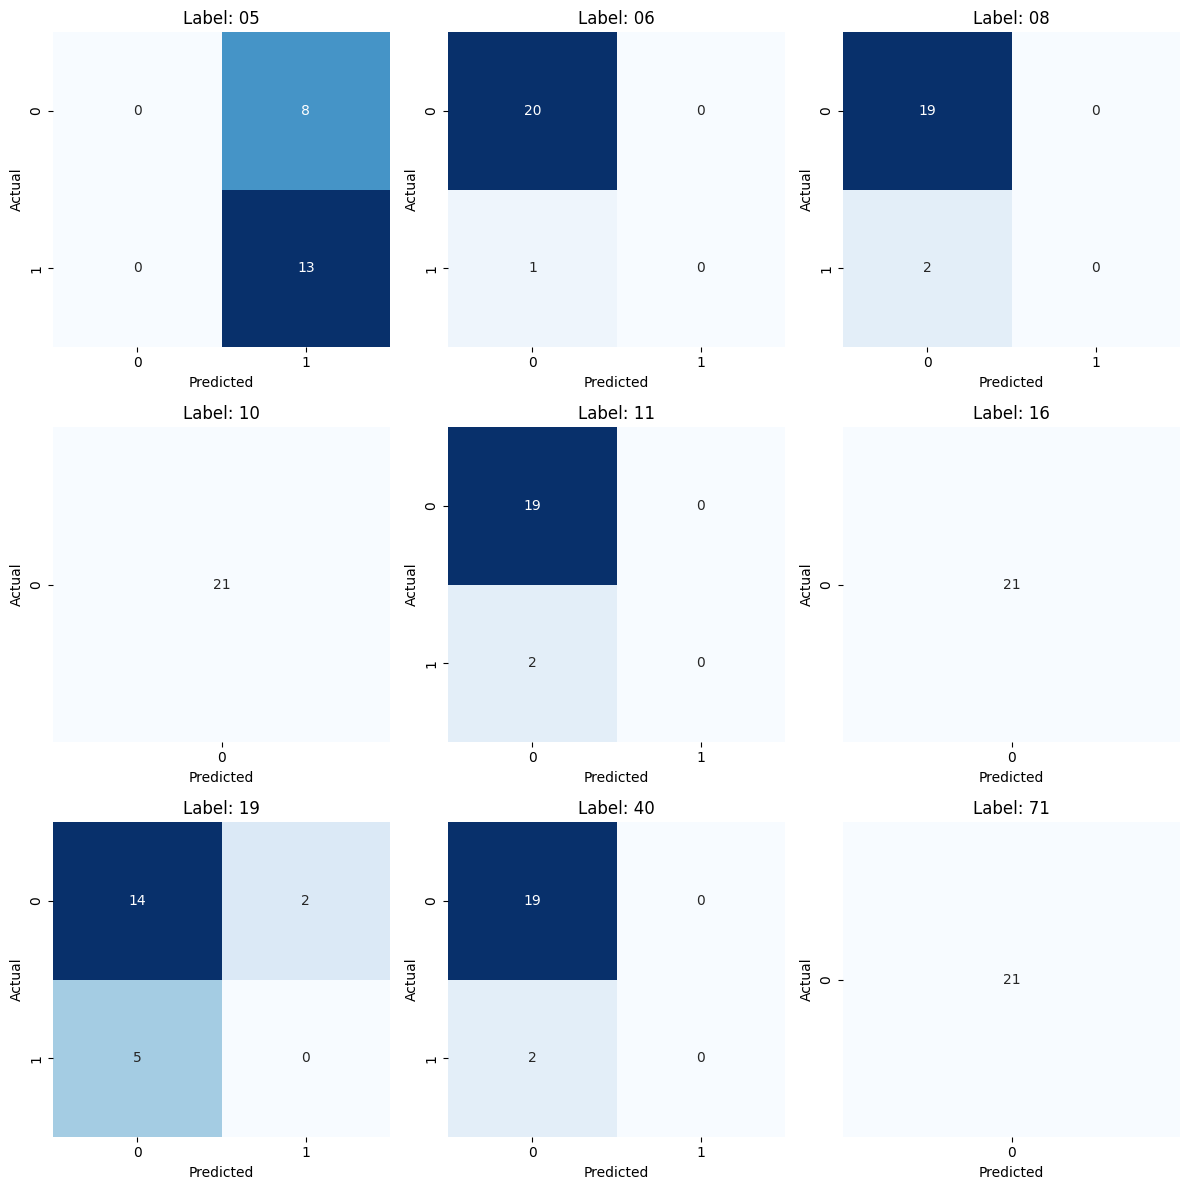

In [71]:
import math

n_labels = len(label_names)
cols = 3
rows = math.ceil(n_labels / cols)

plt.figure(figsize=(12, rows * 4))

for i, label in enumerate(label_names):
    cm = confusion_matrix(Y_test[:, i], Y_pred[:, i])

    plt.subplot(rows, cols, i + 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Label: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


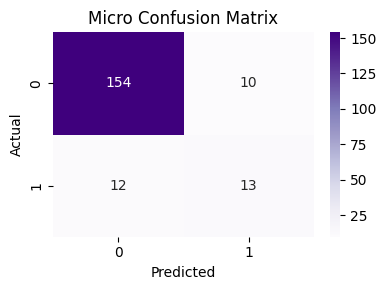

In [72]:
import numpy as np

# flatten
y_true_flat = Y_test.ravel()
y_pred_flat = Y_pred.ravel()

# 전체 confusion matrix (micro)
cm_micro = confusion_matrix(y_true_flat, y_pred_flat)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_micro, annot=True, fmt="d", cmap="Purples")
plt.title("Micro Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
